In [2]:
import catboost as cb
import pandas as pd 
import numpy as np 
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold

In [3]:
df = pd.read_csv('card_transactions.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364342 entries, 0 to 364341
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         364342 non-null  int64  
 1   payment_id                         364342 non-null  int64  
 2   client_id                          364342 non-null  int64  
 3   transaction_date                   364342 non-null  object 
 4   amount_usd                         364342 non-null  float64
 5   card_scheme                        364342 non-null  object 
 6   fraud                              364342 non-null  int64  
 7   mcc                                364342 non-null  object 
 8   transaction_lever                  364342 non-null  int64  
 9   country_code                       364342 non-null  object 
 10  issue_bank_code                    364342 non-null  float64
 11  card_type                          3643

In [5]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [6]:
# transaction date un taze columnlar doretdim, haysy aya hepdan gunine dushyandiklerini gormek un
df['month'] = df['transaction_date'].dt.month
df['day_of_week'] = df['transaction_date'].dt.day_of_week
df["day"] = df["transaction_date"].dt.day
df["hour"] = df["transaction_date"].dt.hour
df["minute"] = df["transaction_date"].dt.minute

In [7]:
df.head()

,Unnamed: 0,payment_id,client_id,transaction_date,amount_usd,card_scheme,fraud,mcc,transaction_lever,country_code,...,count_similar_device_L1M,count_similar_device_L7D,bh_score,addr_dist,network_speed,month,day_of_week,day,hour,minute
0,17,17,384,2019-01-02 00:04:28,100.00,mastercard,0,finance,3,country_87.0,...,0.0,0.0,0.0,0.0,NaN,1,2,2,0,4
1,19,19,384,2019-01-02 00:05:30,186.00,visa,0,retail,1,country_87.0,...,2.0,0.0,NaN,0.0,0.007247,1,2,2,0,5
2,27,27,688,2019-01-02 00:09:32,47.95,visa,0,retail,3,country_87.0,...,0.0,0.0,NaN,0.0,0.207419,1,2,2,0,9
3,28,28,688,2019-01-02 00:09:33,20.00,mastercard,0,retail,2,country_87.0,...,0.0,0.0,NaN,50.0,0.022936,1,2,2,0,9
4,29,29,695,2019-01-02 00:09:39,36.99,visa,0,retail,2,country_87.0,...,0.0,0.0,NaN,0.0,0.036342,1,2,2,0,9


In [8]:
df = df.drop(columns=["transaction_date", "Unnamed: 0", "payment_id"])
# transaction datein indi geregi yok, beyleki iki sutunin correlationi uly bolany un ayyrdym

In [9]:
df.shape

(364342, 42)

In [10]:
cat_features = [col for col in df.columns if df[col].dtype == "object"]
df[cat_features] = df[cat_features].fillna("missing")
num_features = [col for col in df.columns if df[col].dtype == ("float64" or "int64")]

<Axes: >

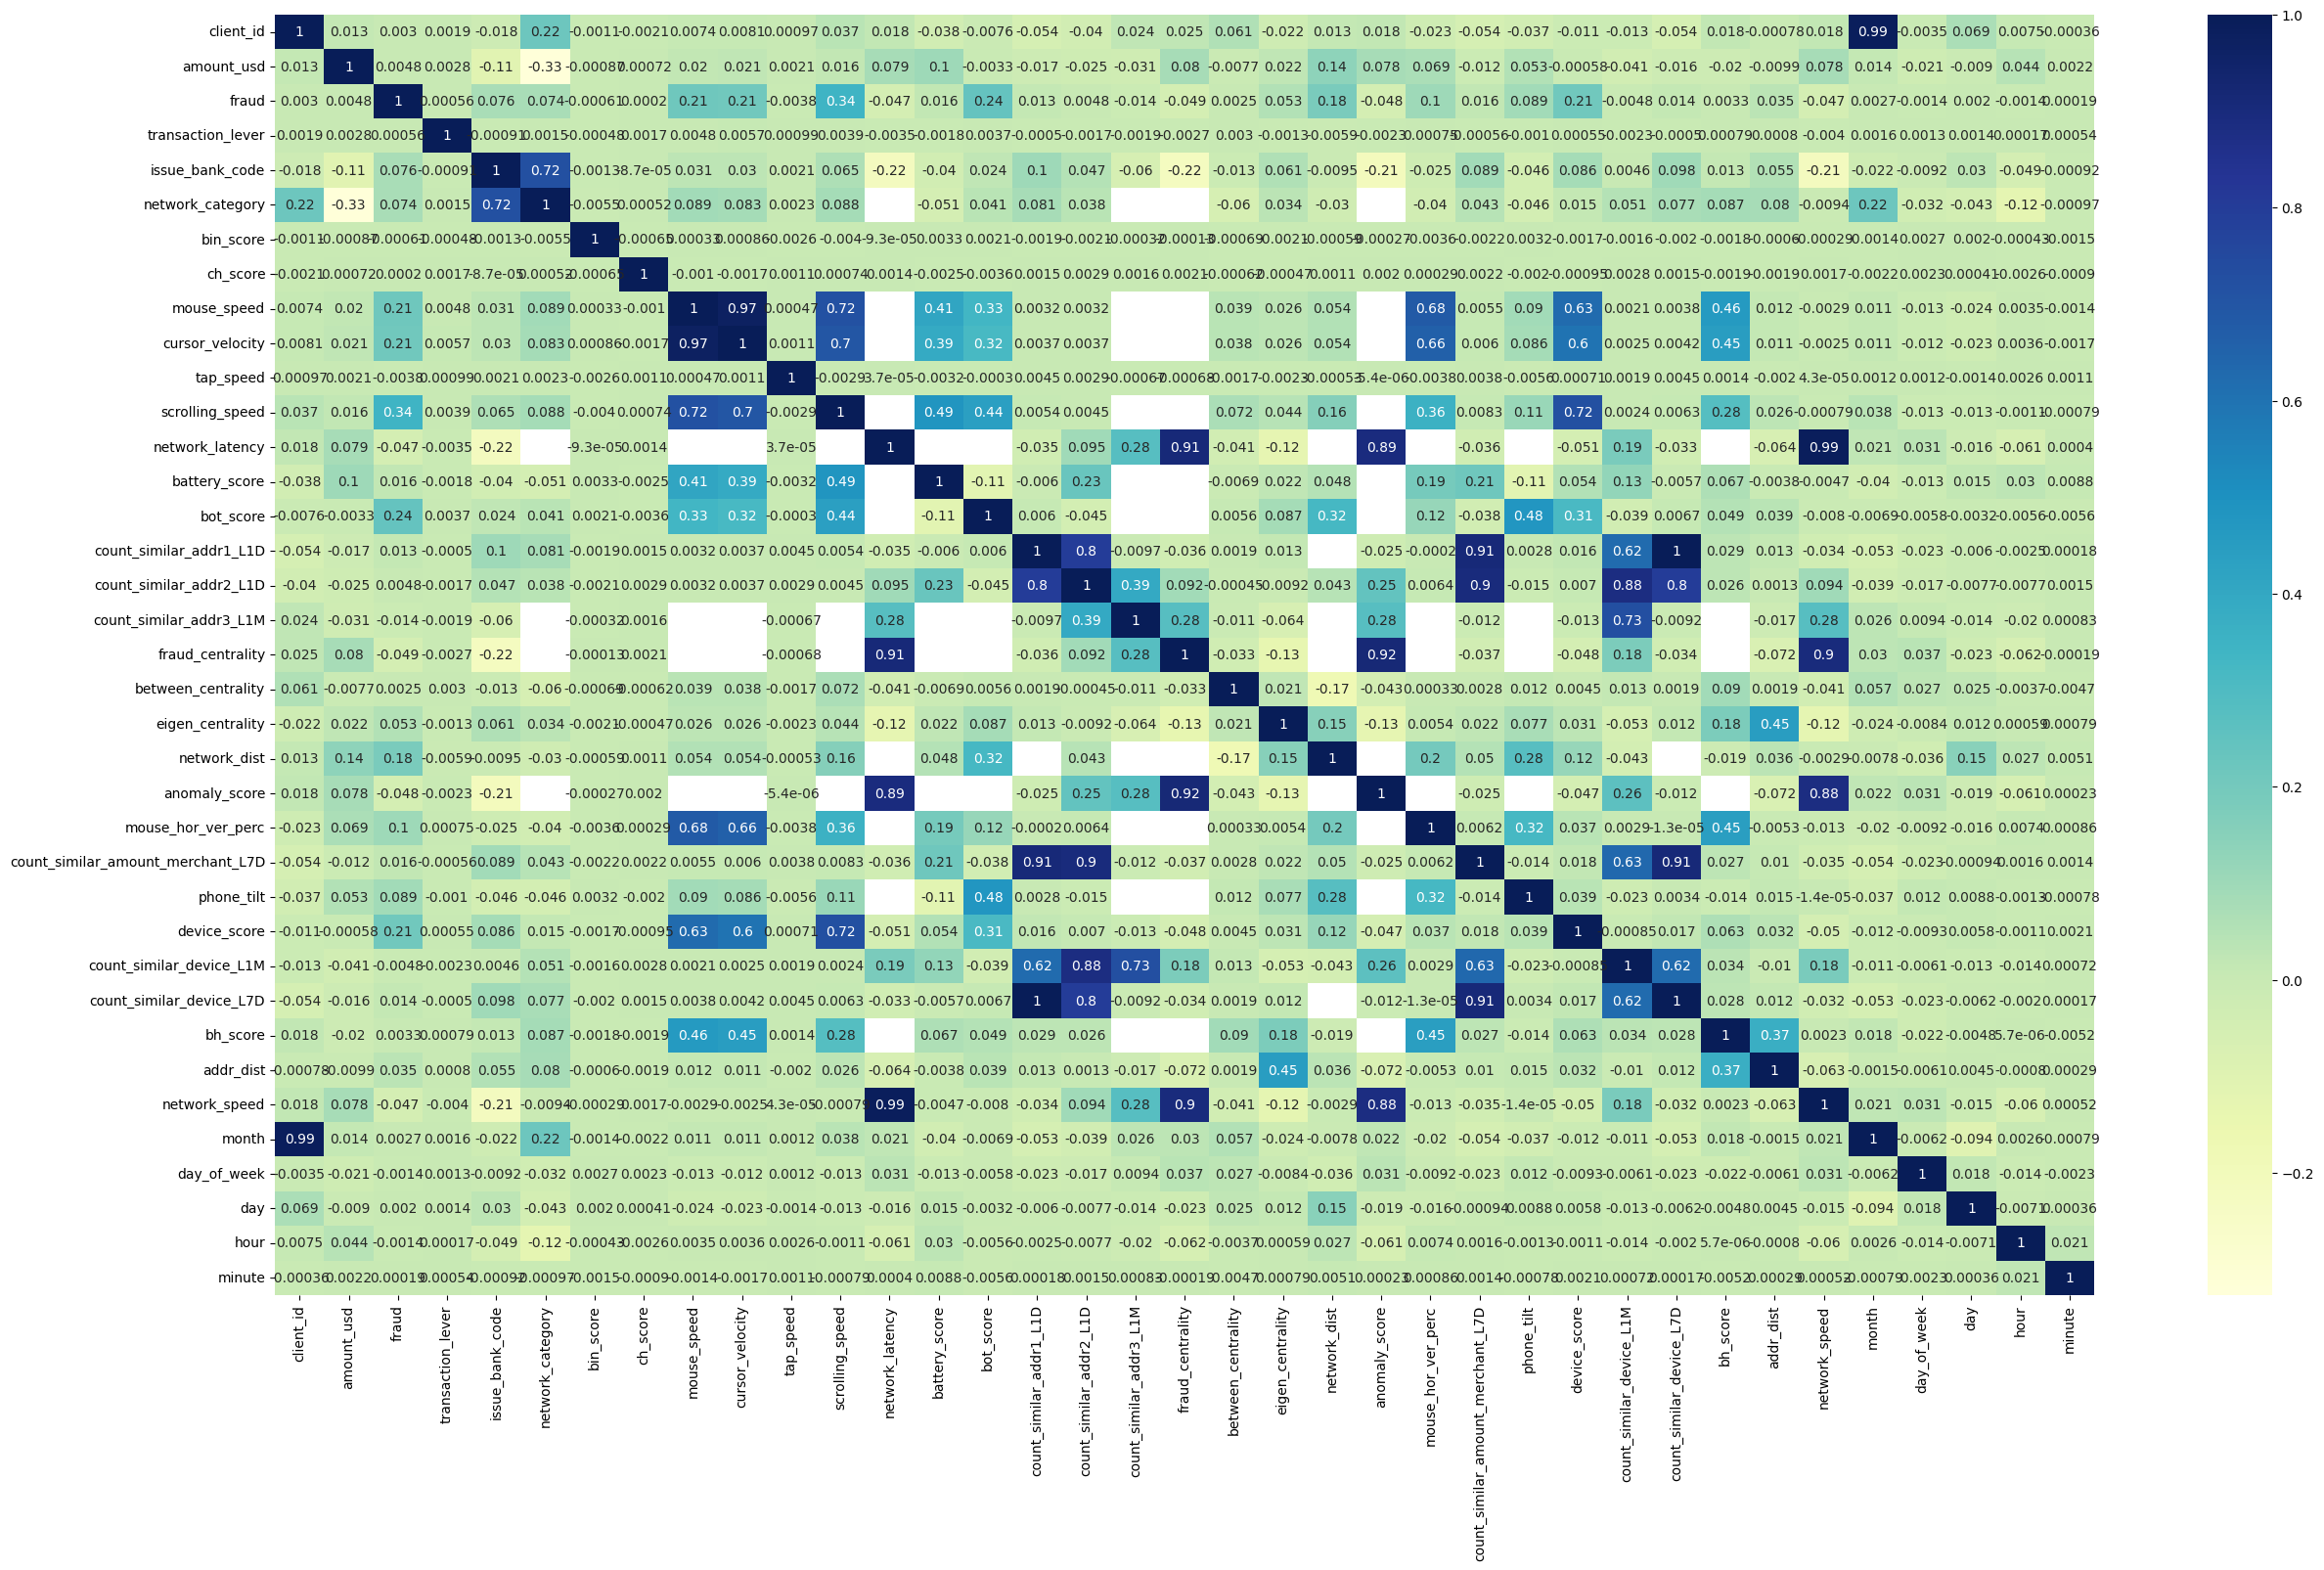

In [11]:
plt.figure(figsize=(30, 17))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='YlGnBu')

**Deleting the columns with correlations above |0.9|**

In [12]:
df = df.drop(columns=["month", "network_latency", "count_similar_device_L7D", "fraud_centrality", "anomaly_score", "count_similar_amount_merchant_L7D", "cursor_velocity"])

In [13]:
# get cat and num features
cat_features = list(df.select_dtypes(include=["object"]).columns)
df[cat_features] = df[cat_features].fillna("missing")
num_features = list(df.select_dtypes(include=["int64", "float64"]).columns)
df[num_features] = df[num_features].fillna(0)

feature_cols = cat_features + num_features
target = "fraud"
feature_cols.remove(target)

In [13]:
feature_cols

['client_id',
 'amount_usd',
 'card_scheme',
 'mcc',
 'transaction_lever',
 'country_code',
 'issue_bank_code',
 'card_type',
 'network_category',
 'proxy_ip',
 'bin_score',
 'ch_score',
 'mouse_speed',
 'tap_speed',
 'scrolling_speed',
 'battery_score',
 'bot_score',
 'count_similar_addr1_L1D',
 'count_similar_addr2_L1D',
 'count_similar_addr3_L1M',
 'between_centrality',
 'eigen_centrality',
 'network_dist',
 'mouse_hor_ver_perc',
 'phone_tilt',
 'device_score',
 'count_similar_device_L1M',
 'bh_score',
 'addr_dist',
 'network_speed',
 'day_of_week',
 'day',
 'hour',
 'minute']

<Axes: >

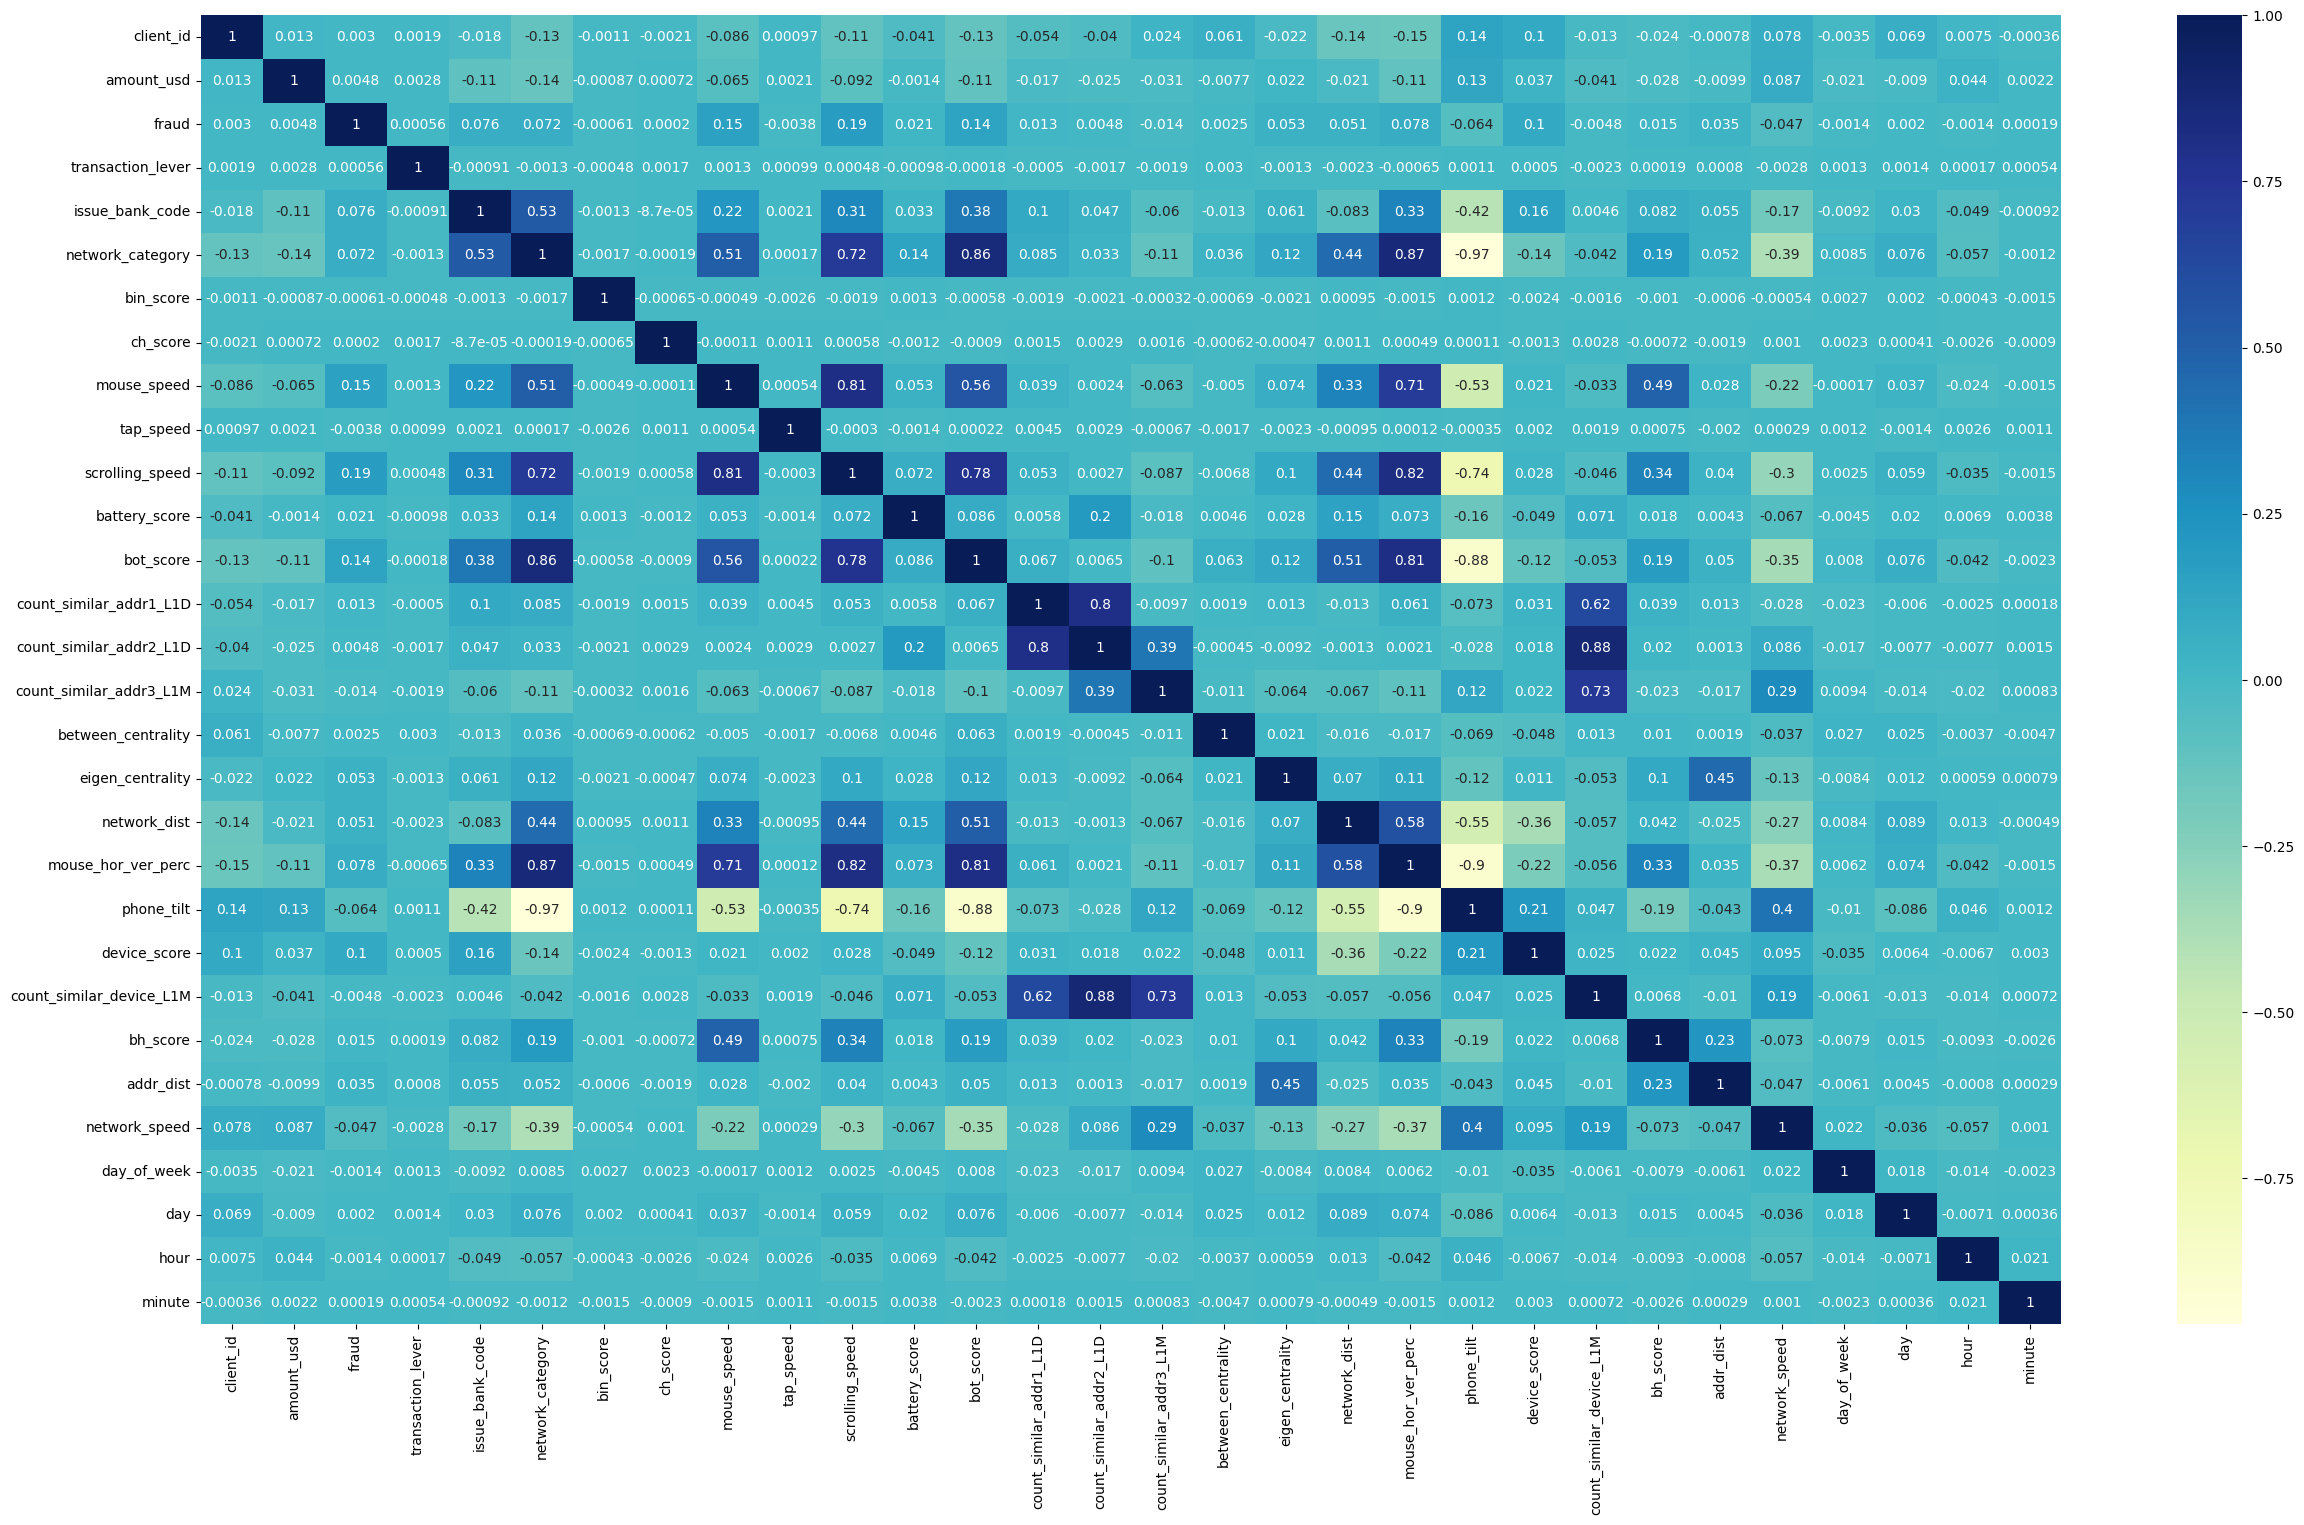

In [14]:
plt.figure(figsize=(30, 17))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='YlGnBu')

In [15]:
shuffled_df = df.sample(frac=1, random_state=42)

In [16]:
df_0 = shuffled_df.loc[shuffled_df.fraud == 0] # fraud bahasy 0-a den bolan rowlar
df_1 = shuffled_df.loc[shuffled_df.fraud == 1] # fraud bahasy 1-a den bolan rowlar

In [25]:
# 500 sany datany validation un ayyryp goydym

df_0_val = df_0.iloc[:500]
df_1_val = df_1.iloc[:500]
df_0_train = df_0.iloc[500:]
df_1_train = df_1.iloc[500:]

In [26]:
# train we validation setleri birikdirdim

train_df = pd.concat([df_0_train, df_1_train]).sample(frac=1, random_state=42)
val_df = pd.concat([df_0_val, df_1_val]).sample(frac=1, random_state=42)

In [27]:
# X we y belledim

X_train = train_df.drop(["fraud"], axis=1)
y_train = train_df["fraud"]
X_val = val_df.drop(["fraud"], axis=1)
y_val = val_df["fraud"]

In [28]:
# fraud imbalansy chozmek :oversampling dine kopyalayar eken shonun un azam bolsa under sample edip ikisinin bahalaryny den geler yaly etdim

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [21]:
# rus = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [22]:
# X_resampled.loc[X_resampled.duplicated()]

In [23]:
params = {
        "iterations": 100,
        "early_stopping_rounds": 10,
        "use_best_model": True,
        "random_seed": 42,
        "learning_rate": 0.1,
        "nan_mode": 'MinInCategorical'
    }

model = cb.CatBoostClassifier(**params)
model.fit(
        X_train,
        y_train,
        cat_features=list(range(len(cat_features))),
        verbose=1000
    )

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=1]=857.25 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [24]:
X_train.head(20)

,client_id,amount_usd,card_scheme,mcc,transaction_lever,country_code,issue_bank_code,card_type,network_category,proxy_ip,...,phone_tilt,device_score,count_similar_device_L1M,bh_score,addr_dist,network_speed,day_of_week,day,hour,minute
173469,13287781,857.250,mastercard,retail,1,country_87.0,150.0,credit,0.0,missing,...,0.0,0.416667,0.0,0.0,0.0,0.168617,1,4,19,1
113711,3512691,150.000,mastercard,finance,3,country_87.0,150.0,credit,166.0,Found,...,-82.0,0.000000,0.0,0.0,0.0,0.000000,0,11,15,42
169169,6437215,30.000,mastercard,retail,2,country_87.0,150.0,debit,0.0,missing,...,0.0,0.000000,0.0,0.0,0.0,0.213038,6,17,12,5
316683,13052373,94.950,visa,retail,1,country_87.0,150.0,debit,0.0,missing,...,0.0,0.208333,38.0,0.0,0.0,0.357240,6,2,1,37
197710,10687228,107.950,mastercard,retail,2,country_87.0,150.0,credit,0.0,missing,...,0.0,0.208333,0.0,0.0,0.0,0.191529,6,5,16,38
177289,6668232,117.000,visa,retail,1,country_87.0,150.0,debit,0.0,missing,...,0.0,0.208333,0.0,0.0,0.0,0.044898,2,20,4,15
107810,12184323,47.950,visa,retail,2,country_87.0,150.0,debit,0.0,missing,...,0.0,0.208333,1.0,0.0,0.0,0.197123,3,23,0,32
311928,9658651,57.950,mastercard,retail,1,country_87.0,150.0,debit,0.0,missing,...,0.0,0.208333,1.0,0.0,0.0,0.199049,1,23,18,56
34059,11033328,310.000,visa,retail,1,country_87.0,150.0,debit,0.0,missing,...,0.0,0.000000,2.0,0.0,0.0,0.049077,3,9,16,56
143793,6931272,57.950,mastercard,retail,3,country_87.0,150.0,debit,0.0,missing,...,0.0,0.208333,0.0,0.0,0.0,0.195236,5,23,5,19


***# 857.25 amount usd daki bahany real dp kabul edenok mugallym, nadip avoid edip bolarka we sizdaki shular yaly yerinde array ulanypsynyz wn onda nm un shu mesele doremedika mugallym***